# Import Required Library

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Add, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings
import os
import nltk 
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Sonu
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Datasets :-> It contains sentences labelled with positive or negative sentiment. The sentences come from three different websites/fields:<b>imdb.com</b> <b>amazon.com</b> <b>yelp.com</b>
<a href='https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences'>Link of datase</a>

In [2]:
text_list = []
label_list = []    
ss = open('sentiment labelled sentences/imdb_labelled.txt' , encoding='utf-8')     # open file imdb_labelled.txt
ss = ss.readlines()
for i in ss:
    text = i.strip().split('\t')
    text_list.append(text[0])
    label_list.append(int(text[1]))
ss = open('sentiment labelled sentences/amazon_cells_labelled.txt' , encoding='utf-8')   # open file amazon_cells_labelled.txt
ss = ss.readlines()
for i in ss:
    text = i.strip().split('\t')
    text_list.append(text[0])
    label_list.append(int(text[1]))
ss = open('sentiment labelled sentences/yelp_labelled.txt' , encoding='utf-8')    # open file yelp_labelled.txt
ss = ss.readlines()
for i in ss:
    text = i.strip().split('\t')
    text_list.append(text[0])
    label_list.append(int(text[1]))
 

## Creating DataFrame

In [3]:
dataframe = pd.DataFrame()
dataframe['Text'] = text_list
dataframe['label'] = label_list


In [4]:
dataframe.head()

,Text,label
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1


### Shuffle the data of dataframe

In [5]:
dataframe = dataframe.sample(frac = 1)
dataframe.head()

,Text,label
1414,After a year the battery went completely dead on my headset.,0
1519,I am not impressed with this and i would not recommend this item to anyone.,0
985,Still it's quite interesting and entertaining to follow.,1
2308,"In the summer, you can dine in a charming outdoor patio - so very delightful.",1
2016,Highly recommended.,1


In [6]:
ss=0
for i in dataframe['label']:
    if i==1:
        ss+=1
print(ss,3000 - ss)

1500 1500


In [7]:
X = dataframe.iloc[: , 0].values
Y = dataframe.iloc[:,1].values

## Splitting dataset into training set and  test set 

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.1,random_state=42)

### Contraction mapping 

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### Removing <i> NOT</i> or <i>NO</i> or <i>very</i> from <b> StopWords</b>

In [10]:
stop_words = set(stopwords.words('english')) 
stop_words.remove('not')
stop_words.remove('no')
stop_words.remove('very')

## Cleaning the text and removing StopWords

In [11]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                              #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in x_train:
    cleaned_text.append(text_cleaner(t,0))

x_train = np.array(cleaned_text)                       # convert the list into array                   

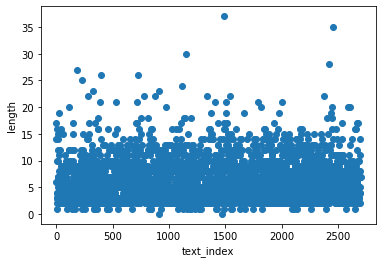

In [12]:
import matplotlib.pyplot as plt
df = pd.DataFrame()
pp=[]
for i in x_train:
    pp.append(len(i.split()))
df['count'] = pp
plt.scatter(range(2700) , df['count'])
plt.ylabel('length')
plt.xlabel('text_index')
plt.show()

### Set the value of max text length

In [13]:
max_text_len= 15

# checking how many text has length less than 200
cnt=0

for i in x_train:
    if(len(i.split())<=max_text_len):
        cnt=cnt+1
    
print(cnt/len(x_train))

0.9688888888888889


### Removing sequence whose length is greater than <i> Max Text length </i>

In [14]:

short_texts=[]
ratings=[]
for i in range(len(x_train)):
    if(len(x_train[i].split())<= max_text_len):
        short_texts.append(x_train[i])
        ratings.append(y_train[i])
x_train = np.array(short_texts)
y_train = np.array(ratings)
df=pd.DataFrame({'text':short_texts,'ratings':ratings})

In [15]:
df.head()

,text,ratings
0,good protection not make phone bulky.,1
1,"ray charles' life provided excellent biographical material film, goes well beyond another movie musician.",1
2,"plot simply rumbles like machine, desperately depending addition new scenes.",0
3,definitely one bad ones.,0
4,camera color balance awful.,0


### Word Embedding from glove

In [16]:
def read_glove_vecs(glove_file):
    f = open(glove_file, encoding="utf-8", errors='ignore')
    word_to_index = {}
    index_to_word = {}
    word_to_vec_map = {}
    i = 0    
    for line in f:
        line = line.strip().split()
        
        curr_word = line[0]
        
        word_to_index[curr_word] = i
        index_to_word[i] = curr_word
        word_to_vec_map[curr_word] = np.asarray(line[1:], dtype=np.float64)
        i+=1
            
    return word_to_index , index_to_word, word_to_vec_map

# function call
word_to_index,index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [17]:
len(word_to_vec_map)

400000

## Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.

In [18]:
def sentences_to_indices(X, word_to_index, maxLen):
       
    m = X.shape[0]                  # number of training examples
    
    
   
    X_indices = np.zeros((m, maxLen))         # Initialize a numpy matrix to zero (to the max len)
    
    for i in range(m):                                               
        sentence_words = X[i].split()       
        j = 0        
        for w in sentence_words:                            
            if w not in word_to_index.keys():
                X_indices[i, j] = word_to_index['unk']
            else:
                X_indices[i, j] = word_to_index[w]            
            j += 1
   
    return X_indices

In [19]:
X_train_indices = sentences_to_indices(x_train, word_to_index, max_text_len)    # Converting the array of sequence to array of indices

## A Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

In [20]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    
    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["rahul"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))   # create embedding matrix
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

##  Create Model using Bidirectional LSTM

In [21]:
from tensorflow.keras import backend as K 
K.clear_session()

# Encoder
sentence_indices = Input(shape=(max_text_len,), dtype='int32')

# Embedding layer
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
enc_emb =  embedding_layer(sentence_indices)   

#encoder lstm1
encoder_lstm1_f = LSTM(128,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_lstm1_r = LSTM(128,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)## ##

encoder_bi1 = Bidirectional(encoder_lstm1_f, backward_layer=encoder_lstm1_r,)
encoder_output1, state_h1, state_c1, state_r_h1, state_r_h1 = encoder_bi1(enc_emb)

#encoder lstm 2
encoder_lstm2_r = LSTM(128,return_sequences=False,return_state=True,dropout=0.4,recurrent_dropout=0.4,go_backwards=True)##
encoder_lstm2_f = LSTM(128,return_sequences=False,return_state=True,dropout=0.4,recurrent_dropout=0.4)

encoder_bi2 = Bidirectional(encoder_lstm2_f, backward_layer=encoder_lstm2_r)
encoder_output2, state_h2, state_c2, state_r_h2, state_r_h2 = encoder_bi2(encoder_output1)

X = Dense(1 , activation = 'sigmoid')(encoder_output2)

# Define the model 
model = Model(inputs = sentence_indices, outputs = X)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional [(None, 15, 256), (None,  183296    
_________________________________________________________________
bidirectional_1 (Bidirection [(None, 256), (None, 128) 394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

## Train the model 

In [23]:
model.fit(X_train_indices, y_train, epochs =20 ,batch_size = 32)

Epoch 1/20
82/82 [==============================] - 8s 92ms/step - loss: 0.6367 - accuracy: 0.6319
Epoch 2/20
82/82 [==============================] - 7s 88ms/step - loss: 0.5661 - accuracy: 0.7091
Epoch 3/20
82/82 [==============================] - 7s 88ms/step - loss: 0.5542 - accuracy: 0.7083
Epoch 4/20
82/82 [==============================] - 7s 83ms/step - loss: 0.5407 - accuracy: 0.7282
Epoch 5/20
82/82 [==============================] - 7s 80ms/step - loss: 0.5286 - accuracy: 0.7339
Epoch 6/20
82/82 [==============================] - 7s 84ms/step - loss: 0.5145 - accuracy: 0.7381
Epoch 7/20
82/82 [==============================] - 7s 89ms/step - loss: 0.5099 - accuracy: 0.7462
Epoch 8/20
82/82 [==============================] - 7s 91ms/step - loss: 0.5000 - accuracy: 0.7523
Epoch 9/20
82/82 [==============================] - 7s 89ms/step - loss: 0.4816 - accuracy: 0.7580
Epoch 10/20
82/82 [==============================] - 7s 90ms/step - loss: 0.4803 - accuracy: 0.7607
Epoch 11/

## Model performance on test data

In [27]:
cleaned_text = []
for t in x_test:
    cleaned_text.append(text_cleaner(t,0))
x_test = np.array(cleaned_text) 

short_texts=[]
label = []
for i in range(len(x_test)):
    if(len(x_test[i].split())<= max_text_len):
        short_texts.append(x_test[i])
        label.append(y_test[i])
       
x_test = np.array(short_texts)
y_test = np.array(label)
x_test_indices = sentences_to_indices(x_test , word_to_index , max_text_len)

In [28]:

loss, acc = model.evaluate(x_test_indices, y_test)
print()
print("Test accuracy = ", acc)

10/10 [==============================] - 0s 9ms/step - loss: 0.4473 - accuracy: 0.8103

Test accuracy =  0.8103448152542114


## Model gives the accuracy 81% on test data ,, 

### Lets try to predict some reviews

In [29]:
y_pred = (model.predict(sentences_to_indices(np.array([' very bad movie ']) , word_to_index , max_text_len)) > 0.5).astype("int32")
y_pred

array([[0]])

In [30]:
y_pred = (model.predict(sentences_to_indices(np.array([' product was very good ']) , word_to_index , max_text_len)) > 0.5).astype("int32")
y_pred

array([[1]])